# mCVaR in-sample analysis - an example 

This is an illustration of *in-sample analysis* workflow. We use a mCVaR (of 3 CVaR's) dispersion measure. 
A similar analysis can be performed for any other implemented dispersion measure. 

We start by importing the **azapy** and other useful packages. 

In [1]:
import numpy as np
import sys
sys.path.append("..")
import azapy as az

print(f"azapy version {az.__version__}")

'0.1.1'

### Collect historical market data for a set of portfolio components

- `symb` is the list of stock symbols (portfolio components).
- `sdate` and `edate` are the start and end dates of historical time-series.
- `mktdir` is the name of the directory used as a buffer for market data collected from the data provider *alphavantage*.
    
> Note: if the flag `force=False` then a reading from `dir=mktdir` is attempted. If it fails, then the data provider servers will be accessed. The new data will be saved to the `mktdir`. *For more information see the `readMkT` documentation*
https://azapy.readthedocs.io/en/latest/.

Check if `mktdir` holds a value convenient for your configuration.

In [2]:
symb = ['GLD', 'TLT', 'XLV', 'VGT', 'PSJ']

sdate = "2012-01-01"
edate = "2021-07-27"

mktdir = "../MkTdata"

mktdata = az.readMkT(symb, sdate=sdate, edate=edate, file_dir=mktdir)

read GLD data from file
read TLT data from file
read XLV data from file
read VGT data from file
read PSJ data from file

Request between 2012-01-01 : 2021-07-27
                    GLD         TLT         XLV         VGT         PSJ
source            yahoo       yahoo       yahoo       yahoo       yahoo
force             False       False       False       False       False
save               True        True        True        True        True
file_dir     ../MkTdata  ../MkTdata  ../MkTdata  ../MkTdata  ../MkTdata
file_format         csv         csv         csv         csv         csv
api_key            None        None        None        None        None
verbose            True        True        True        True        True
error                No          No          No          No          No
nrow               2407        2407        2407        2407        2407
sdate        2012-01-03  2012-01-03  2012-01-03  2012-01-03  2012-01-03
edate        2021-07-27  2021-07-27  2021-07-27

### Set the mixture of CVaR's parameters

- `alpha` - is the list of CVaR confidence levels,
- `coef` - is the list of mixture coefficients. 

>Note: `len(coef)=len(alpha)`. All the coefficients must be `>0`.

In [3]:
alpha = [0.95, 0.90, 0.85]
coef = [0.2, 0.3, 0.5]

### Set the CVaRAnalyzer class.

For a full list of available setting parameters see the documentation.

In [4]:
cr1 = az.CVaRAnalyzer(alpha, coef, mktdata)

### Compute the optimal weights

For numerical illustration we set the optimization type to `Sharpe`. This will produce the weight of the optimal portfolio with maximum C-Sharpe ratio.
The value of the risk-free rate is set to `0`, the default vale.

> Note: `rtype='Sharpe'` is the default setting. Therefore, it does not need to be made explicitly. Other valid values for 
`rtype` are `'Risk'`, `'Sharpe2'`, `'InvNrisk'`, `'MinRisk'` and `'RiskAverse'` (*see the documentation*).

In [5]:
ww1 = cr1.getWeights()
print(f"optimal weights:\n {ww1.round(4)}")

optimal weights:
 symbol
GLD    0.5140
PSJ    0.0709
TLT    0.0582
VGT    0.1684
XLV    0.1885
dtype: float64


### Check the computation status

> Note: Normal exit is `0`. Any other value will signal a type of numerical error and a warning message will be printed during execution.

In [6]:
status = cr1.status
print(f"Status: {status}")

Status: 0


### The risk of the optimal portfolio

In this case it is the value of mCVaR.

In [7]:
risk = cr1.risk
print(f"Risk: {risk}")

Risk: 0.0729118551654855


### Primary risk values

In this case, the *primary risk* is the list of single CVaR's that enter in the mixture.

> Note: If `coef` is normalized to `1`, then `risk = np.dot(coef, primary_risk)`

>Note: The meaning of the *primary risk* varies with the risk measure adopted (*see the documentation*).

In [8]:
primary_risk = cr1.primary_risk_comp
print(f"Primary Risk Components: {primary_risk}")

Primary Risk Components: [0.08452574 0.074498   0.06731462]


### Secondary risk values

In this case, the *secondary risk* is the list of VaR values associated with the CVaR's from *primary risk*.

The meaning of the *secondary risk* varies with the risk measure adopted (*see the documentation*).

In [9]:
secondary_risk = cr1.secondary_risk_comp
print(f"Secondary Risk Components: {secondary_risk}")

Secondary Risk Components: [0.07126387 0.05783101 0.04930353]


### Portfolio expected rate of returns

> Note: It is a simple rate, in algebraic form, with horizon given by the rolling period of the portfolio. In this case a quarter.

In [10]:
RR = cr1.RR
print(f"Rate of Returns: {RR}")

Rate of Returns: 0.04221287251772279


### Sharpe ratio value

>Note: We call Sharpe ratio the ratio between expected excess return (above risk free-rate) and the value of the dispersion measure (in our case mCVaR). 

In [11]:
sharpe = cr1.sharpe
print(f"Sharpe ratio: {np.round(sharpe, 4)}")

Sharpe ratio: 0.579


### View the portfolio frontiers 

- *blue* curve is the efficient frontier. 
- *red* curve is the inefficient frontier.
- Most left *green diamond* - is the *minimum risk portfolio*.
- tangency point *(green diamond)* is the maximum Sharpe portfolio (also called *market* or *tangency* portfolio).
- *blue squares* with stock symbol labels are the portfolio where the entire capital in invested in a single asset (the label designates this asset).
- *green x* with label "1/N" is the equal weighted portfolio (also called *1/N* or *inverse-N* portfolio).
- *green x* with label "InvNrisk" is the efficient portfolio with the same risk as equal weighted portfolio. In our case same mCVaR.
- *blue dots* are random (inefficient) portfolios. They are present here to visualize the area of admissible portfolios.

> Note: See the documentation for more details about available plotting options.

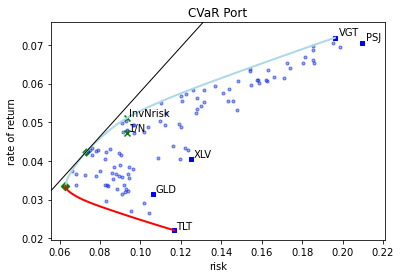

In [12]:
opt ={'title': "CVaR Port", 'tangent': True}

rft = cr1.viewFrontiers(musharpe=0, randomport=100, options=opt)

### View portfolio frontiers in a rate of returns vs. Sharpe ratio representation

This representation gives a better understanding of portfolios efficiency in terms of expected excess returns per unit of risk (in our case per unit of mCVaR).

> Note: In order to avoid recomputations, that may take time, we had reused the graphical information from the previous call to
`viewFrontiers`.

The meanings of the graphical features are the same as in the previous fig.

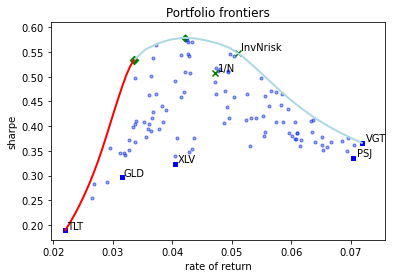

In [13]:
_ = cr1.viewFrontiers(data=rft, fig_type='Sharpe_RR')